In [68]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [42]:
df = pd.read_csv('GlobalLandTemperaturesByState.csv')

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [43]:
df.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
645670,2013-05-01,21.634,0.578,Zhejiang,China
645671,2013-06-01,24.679,0.596,Zhejiang,China
645672,2013-07-01,29.272,1.340,Zhejiang,China
645673,2013-08-01,29.202,0.869,Zhejiang,China
645674,2013-09-01,NaN,NaN,Zhejiang,China


In [44]:
df.isnull().sum()

dt                                   0
AverageTemperature               25648
AverageTemperatureUncertainty    25648
State                                0
Country                              0
dtype: int64

In [45]:
df.dropna(subset=['AverageTemperature', 'AverageTemperatureUncertainty'], inplace=True)

In [46]:
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
State                            0
Country                          0
dtype: int64

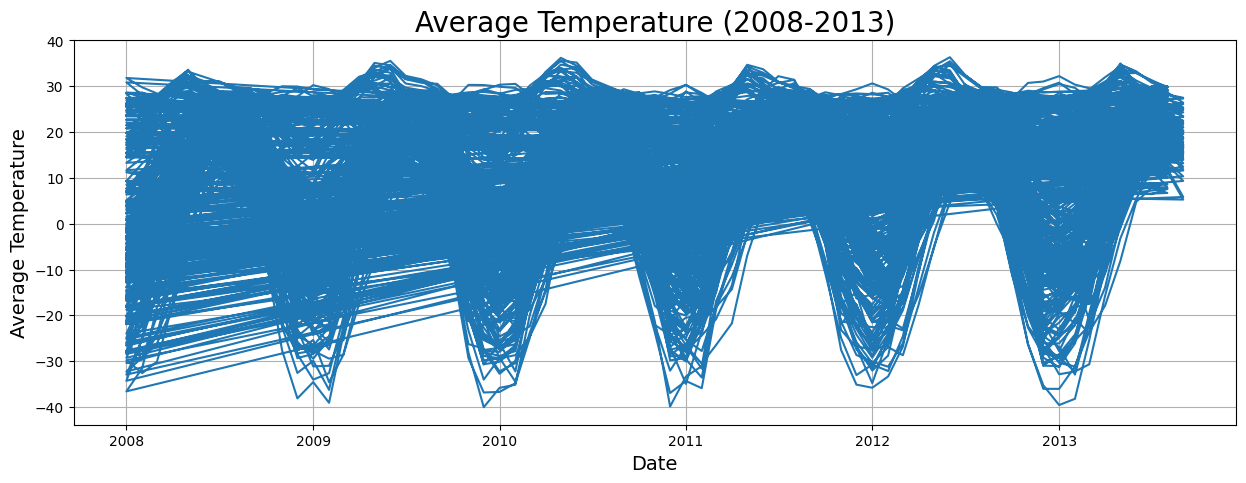

In [47]:
# Konversi kolom 'dt' menjadi tipe data datetime
df['dt'] = pd.to_datetime(df['dt'])

# Filter DataFrame untuk hanya mengambil data dengan tahun antara 2008 dan 2013
df_filtered = df[(df['dt'].dt.year >= 2008) & (df['dt'].dt.year <= 2013)]

# Ambil nilai kolom 'dt' dan 'AverageTemperature' dari DataFrame yang telah difilter
dates = df_filtered['dt'].values
temp = df_filtered['AverageTemperature'].values

plt.figure(figsize=(15, 5))
plt.plot(df_filtered['dt'], temp)
plt.title('Average Temperature (2008-2013)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Temperature', fontsize=14)
plt.grid(True)
plt.show()


In [48]:
scaler = MinMaxScaler()
temp = temp.reshape(-1,1)
temp  = scaler.fit_transform(temp)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(temp, dates, test_size=0.2, shuffle=False)

In [50]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [78]:
train_set = windowed_dataset(X_train, window_size=100, batch_size=100, shuffle_buffer=1000)
test_set  = windowed_dataset(X_test, window_size=100, batch_size=32, shuffle_buffer=1)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [82]:
threshold_mae = (temp.max() - temp.min()) * 10/100
print("Batas maksimal nilai mae (10%) dari data adalah sebesar", threshold_mae)

Batas maksimal nilai mae (10%) dari data adalah sebesar 0.1


In [83]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('mae') < threshold_mae) and (logs.get('val_mae') < threshold_mae)):
      print("MAE < 10% of data scale")
      self.model.stop_training = True
callbacks = myCallback()

In [84]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-03)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


hist = model.fit(train_set,
                    epochs=150,
                    validation_data=test_set,
                    verbose=2,
                    batch_size=20,
                    callbacks=[callbacks])

Epoch 1/150
131/131 - 8s - loss: 0.0091 - mae: 0.0976 - val_loss: 0.0095 - val_mae: 0.1013 - 8s/epoch - 58ms/step
Epoch 2/150
131/131 - 4s - loss: 0.0091 - mae: 0.0975 - val_loss: 0.0095 - val_mae: 0.1007 - 4s/epoch - 33ms/step
Epoch 3/150
MAE < 10% of data scale
131/131 - 5s - loss: 0.0091 - mae: 0.0977 - val_loss: 0.0094 - val_mae: 0.0998 - 5s/epoch - 41ms/step


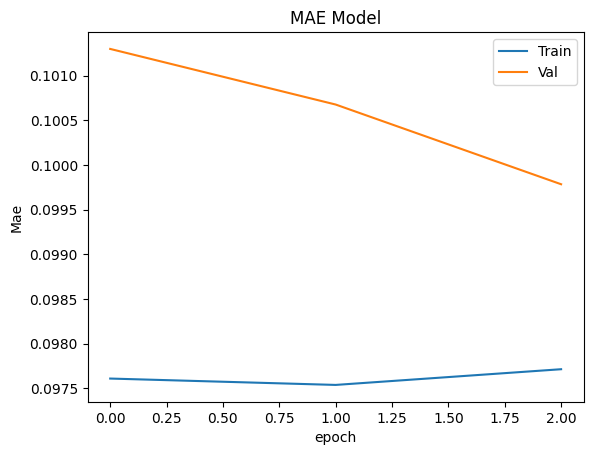

In [85]:
# Plot MAE

plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'],  loc='upper right')
plt.show()

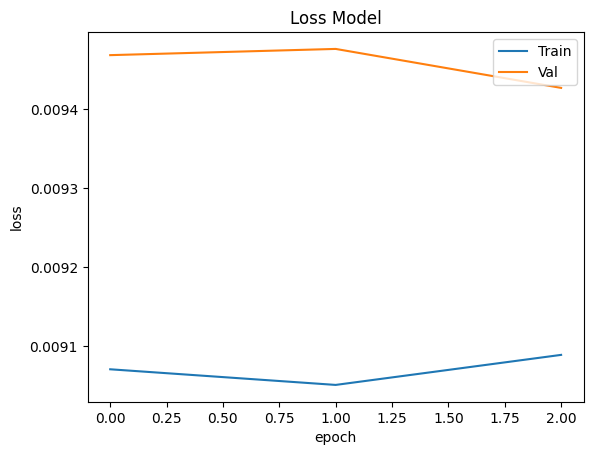

In [86]:
# Plot Loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()